# Racial Bias in Word Embeddings 
Now, we build up on results from [Bolukbasi, Tolga, et al. "Man is to computer programmer as woman is to homemaker? Debiasing word embeddings.](http://papers.nips.cc/paper/6228-man-is-to-computer-programmer-as-woman-is-to-homemaker-debiasing-word-embeddings.pdf)" Advances in Neural Information Processing Systems. 2016.

We examine bias across race/religion.

The author's [code](https://github.com/tolga-b/debiaswe) was a great help.

In [1]:
# First, we download a condensed version of word2vec trained on Google News: 
# https://drive.google.com/open?id=1NH6jcrg8SXbnhpIXRIXF_-KUE7wGxGaG

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from debiaswe import debiaswe as dwe
from debiaswe.debiaswe import we
from debiaswe.debiaswe.we import WordEmbedding
from debiaswe.debiaswe.data import load_professions

### Loading the data

In [4]:
"""Generate Vectors for new words"""
# import gensim
# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# np.set_printoptions(threshold=np.inf, linewidth=300)
# words = ["Christian", "Muslim", "christian", "muslim", "Christianity", "Islam",
#          "Christ", "Allah", "Jesus", "Muhammad", "Jesus", "Mohammed", 
#          "Christmas", "Eid", 
#          "Abraham", "Ibrahim", "Maryam", "Mary", 
#          "Bible", "Quran", "church", "mosque"]

# import pyperclip
# for w in words:
#     try:
#         _ = em.v(w)
#     except KeyError as k:
#         print("\n")
#         print(k)
#         v = np.array2string(model.word_vec(w), max_line_width=301)
#         pyperclip.copy(v)
#         input("Press Enter to continue...")

'Generate Vectors for new words'

In [3]:
# Condensed Word2Vec trained on Google News
em = WordEmbedding('./w2v_gnews_small_mod.txt')

*** Reading data from ./w2v_gnews_small_mod.txt
(26441, 300)
26441 26441 26441
26441 words of dimension 300 : in, for, that, is, ..., Bible, Quran, Christianity, Islam
26441 26441 26441
26441 words of dimension 300 : in, for, that, is, ..., Bible, Quran, Christianity, Islam


### Identifying Bias

In [4]:
pairs = [("Christian", "Muslim"), ("christian", "muslim"), ("Christianity", "Islam"),
         ("Christ", "Allah"), ("Jesus", "Muhammad"), ("Jesus", "Mohammed"), 
         ("Christmas", "Eid"), 
         ("Abraham", "Ibrahim"), ("Maryam", "Mary"), 
         ("Bible", "Quran"), ("church", "mosque")]
for (c,m) in pairs:
    try:
        religion = em.diff(c,m)
    except KeyError as k:
        #TODO: Add vectors for these
        print("{} not in embedding".format(k))
religion_ = em.diff('Christian', 'Muslim')    
pair_pca = we.doPCA(pairs, em)
religion = pair_pca.components_[0]

In [7]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# reduced = pca.fit_transform(np.vstack((gender_, gender)))

### Measuring Bias
We will now use occupations and analogies to measure racial bias.

#### Professions

In [5]:
professions = load_professions()
profession_words = [p[0] for p in professions]

Loaded professions
Format:
word,
definitional female -1.0 -> definitional male 1.0
stereotypical female -1.0 -> stereotypical male 1.0


Let's sort these according to their projection scores.

In [6]:
sorted_r_ = sorted([(em.v(w).dot(religion_), w) for w in profession_words])
sorted_r = sorted([(em.v(w).dot(religion), w) for w in profession_words])

Top Muslim: 
simple: (-0.21718852, 'shopkeeper') | 10-pair: (-0.29478213, 'shopkeeper')
simple: (-0.20208526, 'cleric') | 10-pair: (-0.22428833, 'cleric')
simple: (-0.19617233, 'cab_driver') | 10-pair: (-0.20675695, 'taxi_driver')
simple: (-0.18441933, 'cabbie') | 10-pair: (-0.20075502, 'cab_driver')
simple: (-0.17324007, 'diplomat') | 10-pair: (-0.17178358, 'cabbie')
simple: (-0.16284388, 'envoy') | 10-pair: (-0.16971909, 'parliamentarian')
simple: (-0.15265985, 'senator') | 10-pair: (-0.16862564, 'lawmaker')
simple: (-0.1450511, 'mobster') | 10-pair: (-0.15098548, 'civil_servant')
simple: (-0.14158759, 'maid') | 10-pair: (-0.15029427, 'artiste')
simple: (-0.13048185, 'citizen') | 10-pair: (-0.13602763, 'cartoonist')
simple: (-0.1301453, 'taxi_driver') | 10-pair: (-0.13237397, 'housewife')
simple: (-0.12688039, 'housewife') | 10-pair: (-0.12915629, 'diplomat')
simple: (-0.12511596, 'lyricist') | 10-pair: (-0.12881042, 'journalist')
simple: (-0.12437235, 'waiter') | 10-pair: (-0.126168

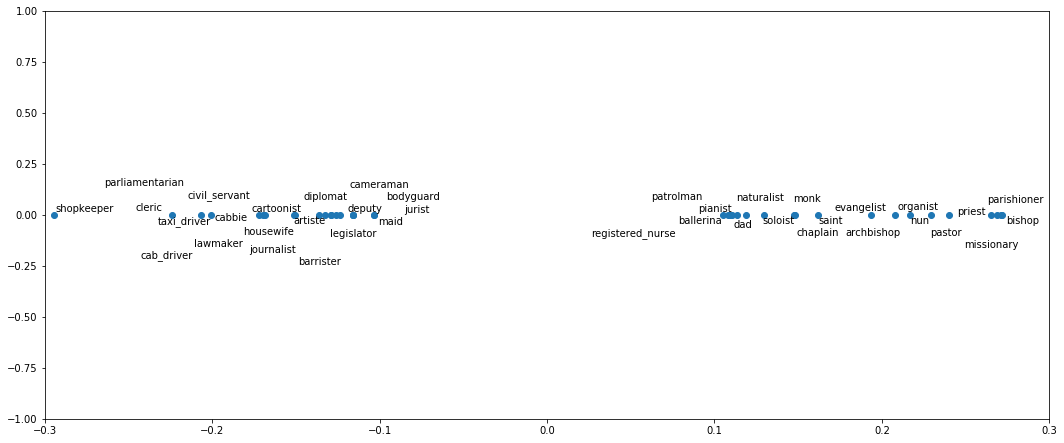

<Figure size 432x288 with 0 Axes>

In [9]:
print("Top Muslim: ")

names = []
points = []
for i in range(0,20):
    points.append(sorted_r[i][0])
    names.append(sorted_r[i][1])
    print("simple: {} | 10-pair: {}".format(sorted_r_[i], sorted_r[i]))
print("\nTop Christian: ")
for i in reversed(range(1, 20)):
    points.append(sorted_r[-i][0])
    names.append(sorted_r[-i][1])
    print("simple: {} | 10-pair: {}".format(sorted_r_[-i], sorted_r[-i]))
    
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

print(points)
print(names)
y = np.zeros(len(points))




fig, ax = plt.subplots()
fig.set_size_inches(18, 7.5)
ax.set_xlim([-.3,.3])
ax.set_ylim([-1,1])
ax.plot(points, y, 'o')

# for i, point in enumerate(points):
#     addToFlip = i*.015 if i%2==0 else -i*.015
#     flip = .05 if i%2==0 else -.05
#     ax.annotate(names[i], (points[i],y[i]),xytext=(points[i], flip+addToFlip))

texts = []
for x, y, s in zip(points, y, names):
    texts.append(plt.text(x, y, s))

adjust_text(texts)
plt.show()
plt.savefig("religion_bias_profession.png")

#### Analogies
Christian is to x as Muslim is to y

In [7]:
a_religion_ = em.best_analogies_dist_thresh(religion_)
a_religion = em.best_analogies_dist_thresh(religion)
basic_a = {a:b for (a,b,c) in a_religion_}
pca_a = {a:b for (a,b,c) in a_religion}

Computing neighbors
Mean: 10.222381906887032
Median: 7.0


In [12]:
print("Analogies: christian -> muslim_1 | muslim_2")
print("word -> simple-axis analogy | PCA analogy\n")
for w in basic_a.keys():
    try:
        print("{} -> {} | {}".format(w, basic_a[w], pca_a[w]))
    except KeyError:
        pass

Analogies: christian -> muslim_1 | muslim_2
word -> simple-axis analogy | PCA analogy

Christian -> religious | religious
christian -> muslim | muslim
churches -> mosques | mosques
Christianity -> Islam | Islam
preacher -> imam | imam
songwriter -> lyricist | lyricist
Kareem -> Mohammed | Mohammed
ministry -> interior_ministry | interior_ministry
pastor -> rabbi | preacher
gospel -> hip_hop | hip_hop
fundamentalist -> jihadi | jihadi
church -> synagogue | synagogue
evangelical -> fundamentalist | fundamentalist
liberal_arts -> undergraduates | undergraduate
volleyball -> badminton | badminton
priest -> cleric | cleric
Christ -> righteousness | righteousness
resurrection -> afterlife | afterlife
traditionalists -> hardliners | hardliners
ecumenical -> interfaith | interfaith
theology -> religions | sociology
musician -> artiste | rapper
Jesus -> prophet | prophet
salvation -> enlightenment | enlightenment
minister -> prime_minister | interior_minister
congregations -> faiths | faiths
sc

Some simple visualizations

In [13]:
we.viz(a_religion_)

   0                    Christian | religious                    0.60
   1                    christian | muslim                       0.57
   2                    religious | Muslim                       0.50
   3                     churches | mosques                      0.48
   4                 Christianity | Islam                        0.43
   5                     preacher | imam                         0.36
   6                   songwriter | lyricist                     0.32
   7                    preachers | imams                        0.32
   8                       Kareem | Mohammed                     0.31
   9                     ministry | interior_ministry            0.30
  10                       pastor | rabbi                        0.30
  11                       gospel | hip_hop                      0.30
  12               fundamentalist | jihadi                       0.28
  13                       church | synagogue                    0.28
  14                

In [14]:
we.viz(a_religion)

   0                     churches | mosques                      0.66
   1                 Christianity | Islam                        0.64
   2                    christian | muslim                       0.53
   3                       priest | cleric                       0.51
   4                        Jesus | prophet                      0.46
   5                      priests | clerics                      0.44
   6                    synagogue | mosque                       0.42
   7                            y | el                           0.41
   8                     preacher | imam                         0.40
   9                  evangelical | fundamentalist               0.39
  10                       divine | Allah                        0.39
  11                       faiths | Muslim                       0.39
  12                       Keisha | Aisha                        0.39
  13                         monk | villager                     0.37
  14                